# KMeans 实现和应用

## KMeans 算法原理

KMeans 是一种基本的动态聚类算法，核心思想是每个点都归属于它离得最近的质心代表的点。

KMeans 算法的基本步骤如下

- 随机挑选 k 个点作为初始的聚类质心

- 计算每个点到每个质心的距离，根据距离把每个点划分到离它最近的质心所属的 cluster

- 重新计算质心，如果质心无变化，则迭代结束，否则回到上一步

在基础的 KMeans 算法的基础上，还可以在第一步选择质心的步骤上进行优化，以选择更好的初值。

KMeans 的优化版本叫做 KMeans ++，其和 KMeans 唯一的不同在于第一步选择质心。

KMeans++ 想要让初始时选择的 k 个质心之间距离尽可能远，具体的方法是:

- 首先挑出一个样本点作为第一个质心

- 计算其他样本点到第一个质心的距离 $D(x)$，计算被选择的概率 $\frac{D(x)^2}{\Sigma D(x^{(i)})^2}$，并根据轮盘法选择下一个质心

- 重复直到选出 K 个质心

## KMeans 算法实现

In [1]:
import numpy as np

In [22]:
class KMeans:
    def __init__(self, n_clusters: int = 8, init: str = 'k-means++', max_iter: int = 300, tol: float = 0.0001):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.tol = tol

        self.cluster_centers_ = None
        self.dist = None
        self.labels_ = None

    def __gen_center(self, X_train):
        n_sample, n_feature = X_train.shape

        if self.init == 'random':
            # 为了在数据范围内产生随机质心，首先计算各特征的统计量
            f_mean = np.mean(X_train, axis=0)
            f_std = np.std(X_train, axis=0)
            self.cluster_centers_ = f_mean + np.random.randn(self.n_clusters, n_feature) * f_std

        elif self.init == 'k-means++':
            # 第一个质心随机选
            idx = np.random.randint(0, n_sample)
            self.cluster_centers_ = [X_train[idx, :]]

            # 选出后面k-1个质心
            for i in range(1, self.n_clusters):
                dist = np.zeros((n_sample, len(self.cluster_centers_)))  # 各样本到质心的距离矩阵
                for cent_idx in range(len(self.cluster_centers_)):
                    dist[:, cent_idx] = np.linalg.norm(
                        X_train - self.cluster_centers_[cent_idx], axis=1)

                dist = np.min(dist, axis=1)  # 所有样本离各质心距离的最小值
                p = dist / np.sum(dist)  # 归一化后的最小距离当做概率进行下一个质心的选取，这里没有计算平方

                next_cent_idx = np.random.choice(n_sample, p=p)
                self.cluster_centers_.append(X_train[next_cent_idx])
            self.cluster_centers_ = np.array(self.cluster_centers_)

    def fit(self, X_train):
        n_sample, n_feature = X_train.shape

        self.__gen_center(X_train)
        self.dist = np.zeros((n_sample, self.n_clusters))

        cent_pre = np.zeros(self.cluster_centers_.shape)
        cent_move = np.linalg.norm(self.cluster_centers_ - cent_pre)

        epoch = 0
        from copy import deepcopy
        while epoch < self.max_iter and cent_move > self.tol:
            epoch += 1

            # 首先计算每个样本离每个质心的距离
            for i in range(self.n_clusters):
                self.dist[:, i] = np.linalg.norm(X_train - self.cluster_centers_[i], axis=1)

            # 样本对应的类别为距离最近的质心
            self.labels_ = np.argmin(self.dist, axis=1)

            cent_pre = deepcopy(self.cluster_centers_)

            # 计算每个类别下的均值坐标，更新质心
            for i in range(self.n_clusters):
                self.cluster_centers_[i] = np.mean(X_train[self.labels_ == i], axis=0)

            cent_move = np.linalg.norm(self.cluster_centers_ - cent_pre)

    def predict(self, X_test):
        n_sample = X_test.shape[0]
        dist_test = np.zeros((n_sample, self.n_clusters))

        for i in range(self.n_clusters):
            dist_test[:, i] = np.linalg.norm(X_test - self.cluster_centers_[i], axis=1)
        clus_pred = np.argmin(dist_test, axis=1)

        return clus_pred

## KMeans 聚类结果可视化

随机生成一组数据，来看看 KMeans 算法的效果

In [12]:
X = np.random.random((50, 2)) + np.random.randint(-5, 5, size=[50, 2])

In [13]:
X

array([[ 3.93377173,  3.4943646 ],
       [ 1.6990287 , -4.0679839 ],
       [-2.70975119,  2.59838541],
       [ 0.11291988, -2.10125498],
       [-3.85076255, -2.26612343],
       [ 0.56221499, -1.25893431],
       [-3.01626525, -2.25978288],
       [-2.04056193,  0.3689479 ],
       [ 4.96906369, -1.99702136],
       [ 2.72909534, -0.93983087],
       [-0.98722976,  0.82937377],
       [ 3.68612319, -3.64760882],
       [-2.20339282,  3.56443267],
       [-0.47242685,  1.14191097],
       [-0.64411085, -1.13629272],
       [ 1.87247836,  2.30625894],
       [-1.73611841,  3.23112546],
       [ 0.96526217, -4.27345817],
       [ 3.20907319,  3.68826606],
       [-2.35185217,  1.90734629],
       [-1.55146212, -2.71410014],
       [ 1.79060748,  2.19754934],
       [ 4.31818284, -0.23317553],
       [-3.46860289, -2.39324454],
       [-1.85662638, -3.99172959],
       [-2.71545069, -3.91800941],
       [-1.52845728,  0.52964772],
       [ 3.72710908,  0.50005197],
       [-4.14172908,

In [14]:
import matplotlib.pyplot as plt

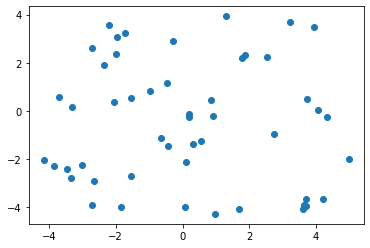

In [15]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [23]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

In [24]:
labels = kmeans.predict(X)

In [27]:
labels

array([1, 4, 3, 2, 0, 2, 0, 3, 4, 4, 3, 4, 3, 3, 2, 1, 3, 4, 1, 3, 0, 1,
       4, 0, 0, 0, 3, 1, 0, 2, 4, 1, 0, 2, 1, 3, 0, 3, 2, 2, 3, 2, 4, 4,
       0, 2, 3, 4, 4, 3], dtype=int64)

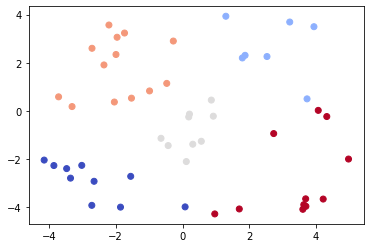

In [28]:
plt.scatter(X[:,0], X[:,1], c = labels, cmap='coolwarm')
plt.show()

可以看到结果基本上符合我们肉眼的观察。

## KMeans 实现图像分割

下面将用 KMeans 算法实现无监督的图像分割，我这里采用的是按照颜色作为分割标准。

具体来说，包括以下几步:

- 把每个像素映射到 rgb 空间中的点

- 做聚类

- 把结果转成可展示的图片

In [29]:
import cv2

In [30]:
image = cv2.imread('image.png')

以下是原始图片，我选取了我觉得不错的一幅 AI 创作的画

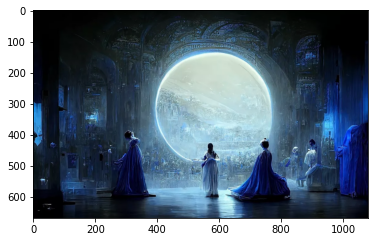

In [33]:
plt.imshow(image)

In [35]:
# resize 到合适的大小
image = cv2.resize(image, (256, 256))

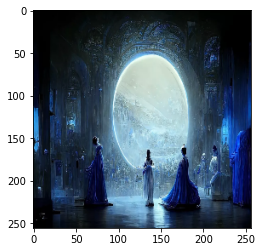

In [36]:
plt.imshow(image)

In [39]:
image

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]],

       ...,

       [[2, 0, 2],
        [2, 0, 2],
        [2, 0, 2],
        ...,
        [1, 2, 7],
        [0, 2, 4],
        [2, 2, 4]],

       [[2, 0, 2],
        [2, 0, 2],
        [2, 0, 2],
        ...,
        [2, 1, 6],
        [1, 0, 3],
        [1, 0, 3]],

       [[2, 0, 2],
        [2, 0, 2],
        [2, 0, 2],
        ...,
        [2, 1, 5],
        [1, 0, 3],
        [1, 0, 3]]], dtype=uint8)

In [40]:
image.shape

(256, 256, 3)

In [47]:
# 把每个像素看成 rgb 空间中的点，整张图片一共有 65536 个点
# 我这里是根据颜色聚类，因此在 rgb 空间里
dots = []
for i in range(256):
    for j in range(256):
        dots.append(image[i,j,:])

In [51]:
len(dots)

65536

In [53]:
dots = np.array(dots)

In [54]:
dots.shape

(65536, 3)

In [109]:
segmentor = KMeans(n_clusters=3)
segmentor.fit(dots)
labels = segmentor.predict(dots)

In [110]:
labels

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [111]:
# 给不同类别准备的颜色
colors = [[0,0,1.], [0., 0., 0.], [1., 1., 1.]]

In [112]:
# 把每个点染上对应类别的颜色
segmented = np.zeros((256, 256, 3))
for i in range(256):
    for j in range(256):
        index = i * 256 + j
        segmented[i,j,:] = colors[labels[index]]

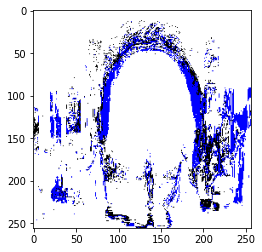

In [113]:
plt.imshow(segmented)

可以看到基本上画中间的圆圈和人的形状都出来了